In [ ]:
# Modules

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import csv
from grid_search import *


# Files 
x_train_csv = "dataset/x_train.csv"
y_train_csv = "dataset/y_train.csv"
x_test_csv = "dataset/x_test.csv"



### Grid search analysis for hyperparameter tuning

In [6]:
# Read x_train and y_train
X_train, features = csv_to_array("dataset/x_train.csv")
Y_train, labels = csv_to_array("dataset/y_train.csv")
# Flatten y_train to convert into 1d array
Y_train = Y_train.flatten()
# Y modification
Y_train = np.where(Y_train == -1, 0, Y_train)

x_train = X_train

# Modifying BPHIGH4 column
index_BPHIGH4 = features.index('BPHIGH4')
x_train[:, index_BPHIGH4] = np.where(x_train[:, index_BPHIGH4] == 4, 1, x_train[:, index_BPHIGH4])
x_train[:, index_BPHIGH4] = np.where((x_train[:, index_BPHIGH4] == 2) | (x_train[:, index_BPHIGH4] == 3), 0, x_train[:, index_BPHIGH4])


# Consistent scaling (wont use 'EXEROFIT1')
columns_to_scale = ['ALCDAY5', 'STRENGTH']
indices = [features.index(col) for col in columns_to_scale]
# Select the columns
selected_columns = x_train[:, indices]

# Preprocessing special values
#  777/999 -> np.nan
selected_columns = np.where(np.isin(selected_columns, [777, 999]), np.nan, selected_columns)
# 888->0
selected_columns = np.where(selected_columns == 888, 0, selected_columns)


# If value smaller than 200, days per week entry; set additional condition; so 0 not modified
mask_dw = (selected_columns > 0) & (selected_columns < 200)
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dw] = (np.char.lstrip(selected_columns[mask_dw].astype(str), '1').astype(float)) * 4.345 

# If value greater than 200, days per month
mask_dm = selected_columns > 200
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dm] = (np.char.lstrip(selected_columns[mask_dm].astype(str), '2').astype(float)) 


# Binary conversion for STRENGTH and ALCDAY5
# STRENGTH: 0 if > 0, otherwise 1
strength_index = columns_to_scale.index('STRENGTH')
# Perserve Nans
selected_columns[:, strength_index] = np.where(
    np.isnan(selected_columns[:, strength_index]),
    np.nan,
    np.where(selected_columns[:, strength_index] > 0, 0, 1)
)

# ALCDAY5: 0 if > 0, otherwise 1
alcday_index = columns_to_scale.index('ALCDAY5')
selected_columns[:, alcday_index] = np.where(
    np.isnan(selected_columns[:, alcday_index]),
    np.nan,
    np.where(selected_columns[:, alcday_index] > 0, 0, 1)
)

# Update x_train with the transformed columns
x_train[:, indices] = selected_columns


# JOINPAIN
# Binary conversion
"""
joinpain_index = features.index('JOINPAIN')
# Perserve Nans
x_train[:, joinpain_index] = np.where(np.isnan(x_train[:, joinpain_index]), np.nan,
    np.where(x_train[:, joinpain_index] > 7, 1, 0))

# Poorhlth Binary
poorh_index = features.index('POORHLTH')
x_train[:, poorh_index] = np.where(np.isin(x_train[:, poorh_index], [77, 99]), np.nan, x_train[:, poorh_index])
# Need to add condition so 88 (None) -> 0
# Preserve NaNs and apply binary transformation for CHECKUP
x_train[:, poorh_index] = np.where(
    np.isnan(x_train[:, poorh_index]), 
    np.nan,  # Keep NaNs as they are
    np.where((x_train[:, poorh_index] < 31) & (x_train[:, poorh_index] > 2), 1, 0)  # Set to 1 if equal to 1, otherwise 0
)

"""

# CHECKUP Binary
checkup_index = features.index('CHECKUP1')
x_train[:, checkup_index] = np.where(np.isin(x_train[:, checkup_index], [7, 9]), np.nan, x_train[:, checkup_index])
# Preserve NaNs and apply binary transformation for CHECKUP
# Values = None = 8 -> 0 (since different than 1)
x_train[:, checkup_index] = np.where(
    np.isnan(x_train[:, checkup_index]), 
    np.nan,  # Keep NaNs as they are
    np.where(x_train[:, checkup_index] == 1, 1, 0)  # Set to 1 if equal to 1, otherwise 0
)




# Creating BMI column
# Need processing for 7777, 9999, np.nan 
# First convert entries = 7777,9999 -> np.nan

# 1. From kgs to pounds ('WEIGTH2' column)
index_WEIGHT2 = features.index('WEIGHT2')
# Refused and not sure entries
x_train[:, index_WEIGHT2] = np.where(np.isin(x_train[:, index_WEIGHT2], [7777, 9999]), np.nan, x_train[:, index_WEIGHT2])

# Apply to values greater than 9000
mask = x_train[:, index_WEIGHT2] > 8999
# Convert to string, strip the first character if it's '9', then convert back to float
x_train[mask, index_WEIGHT2] = np.char.lstrip(x_train[mask, index_WEIGHT2].astype(str), '9').astype(float)
# Convert from kg to pounds
x_train[mask, index_WEIGHT2] *= 2.20462

# 2. From cm to in ('HEIGHT3' column)
index_HEIGHT3 = features.index('HEIGHT3')
# Not sure, refused values
x_train[:, index_HEIGHT3] = np.where(np.isin(x_train[:, index_HEIGHT3], [7777, 9999]), np.nan, x_train[:, index_HEIGHT3])

# i. cm -> in
# Apply transformation to values greater than 9000
mask_cm = (x_train[:, index_HEIGHT3] > 8999)
# Convert to string, strip the first character '9', convert back to float, and convert from cm to feet
x_train[mask_cm, index_HEIGHT3] = np.char.lstrip(x_train[mask_cm, index_HEIGHT3].astype(str), '9').astype(float)
x_train[mask_cm, index_HEIGHT3] *= 0.393701  # Convert from cm to in

# ii. ftin -> in
mask_ftin = x_train[:, index_HEIGHT3] < 8999
# Ex:  504 -> 5*12 + 4 = 64 inches
x_train[mask_ftin, index_HEIGHT3] = (x_train[mask_ftin, index_HEIGHT3] // 100) * 12 + (x_train[mask_ftin, index_HEIGHT3] % 100)

# Extract the height in inches and weight in pounds for BMI calculation
height_in_inches = x_train[:, index_HEIGHT3] 
weight_in_pounds = x_train[:, index_WEIGHT2] 

# Calculate BMI using the formula
bmi = (weight_in_pounds * 703) / (height_in_inches ** 2) # multiplying by 703 (so metric units)

# Define bins for bmi

'''

bmi_bins = [0, 16, 24.9, 29.9, 250]  # Underweight, Normal, Overweight, Obese
bmi_risk_values = [3, 0, 1, 2]   # 0: Normal, 1: Overweight, 2:Obese, 3: Underweight (ordered by risk)

# Digitize BMI values, excluding NaNs
bmi_category = np.where(np.isnan(bmi), np.nan, np.digitize(bmi, bins=bmi_bins, right=True))

# Map digitized values to risk values, keeping NaNs as NaN
bmi_numerical = np.array([
    bmi_risk_values[int(bin_idx) - 1] if not np.isnan(bin_idx) and 1 <= bin_idx <= len(bmi_risk_values) else np.nan
    for bin_idx in bmi_category
])
'''
# Define BMI as binary
bmi_binary = np.where((bmi >= 16) & (bmi < 24.9), 0, 1)


# Add the BMI column to x_train
x_train = np.column_stack((x_train, bmi_binary))

# Add column name to feature list
features.append('BMI')


# Creating average fruit and vegetable consumption
# Indices of the columns to average
columns_to_average = ['FRUTDA1_', 'VEGEDA1_', 'GRENDAY_', 'ORNGDAY_', 'BEANDAY_']
indices = [features.index(col) for col in columns_to_average]

# Select the columns
selected_columns = x_train[:, indices]

# Calculate the average while ignoring NaN values
# np.nanmean computes the mean ignoring NaN values
# If all values are missing in a row, np.nanmean will return NaN
average_column = np.nanmean(selected_columns, axis=1)

# Convert into binary
binary_avg_fruit_veg = np.where(average_column > 0.6, 0, 1)


# Add the new average column to x_train
x_train = np.column_stack((x_train, binary_avg_fruit_veg ))

# Add the new feature name to the features list
features.append('AVG_FRUITS_VEGS')

C:\Users\beaiz\AppData\Local\Temp\ipykernel_19512\644160873.py:176: RuntimeWarning: Mean of empty slice
  average_column = np.nanmean(selected_columns, axis=1)


In [71]:
# NO REGULARIZATION
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
# Define parameter ranges for the grid search
gamma_values = [0.1, 0.05, 0.01, 0.005, 0.001]
max_iters_values = [50, 150, 250, 450, 1000]
N_values = [512, 1024, 2048, Y_train_balanced.shape[0]]
prob_threshold_values = [0.5]
beta1_values = [0.9]  
beta2_values = [0.98] 

# Initialize a list to store results for each combination
grid_search_results = []
r = 29

# Perform grid search
for gamma, max_iters, batch, prob_threshold, beta1, beta2 in itertools.product(
        gamma_values, max_iters_values, N_values, prob_threshold_values, beta1_values, beta2_values):
    
    # Run evaluation with current parameter combination
    result = evaluate_feature_combinations_with_mandatory(
       features_dict=features_dict,
       X_train_balanced=X_train_balanced,
       Y_train_balanced=Y_train_balanced,
       r=r,
       mandatory_features=mandatory_features,
       max_iters=max_iters,
       gamma=gamma,
       beta1=beta1,
       beta2=beta2,
       reg_norm='',
       prob_threshold=prob_threshold,
       batch_size=batch,
       plot=False
    )
    print(f'gamma: {gamma}')
    # Store the result and parameters for analysis
    grid_search_results.append({
        'gamma': gamma,
        'max_iters': max_iters,
        'batch_size': batch,
        'prob_threshold': prob_threshold,
        'beta1': beta1,
        'beta2': beta2,
        'F1_score': result[0]['F1_score'],
        'Accuracy': result[0]['Accuracy']
    })

# Output or analyze grid_search_results
grid_search_results


gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.001
gamma: 0.001
gamma: 0.001
g

[{'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7590046981033582,
  'Accuracy': 0.7610008628127696},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 1024,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7868369351669942,
  'Accuracy': 0.7753235547886109},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 2048,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7815414825724104,
  'Accuracy': 0.7696289905090595},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 57950,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7620180057754374,
  'Accuracy': 0.7582398619499569},
 {'gamma': 0.1,
  'max_iters': 150,
  'batch_size': 512,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7348718880610576,
  'Accuracy': 0.7482312338222605},
 {'gamma': 0.1,
  'max_iters': 150,
  'batch_size': 1024,
  'prob_threshold': 0.

In [72]:
# Sort grid search results by Accuracy in descending order, and F1_score as secondary criterion
sorted_grid_search_results = sorted(
    grid_search_results, 
    key=lambda x: (x['Accuracy'], x['F1_score']), 
    reverse=True
)

# Print the sorted results from best to worst by accuracy
print("Grid Search Results (sorted by Accuracy):")
for result in sorted_grid_search_results:
    print(result)

# Display the best parameter combination (first item in the sorted list)
best_result = sorted_grid_search_results[0]
print("\nBest Parameter Combination:")
print(best_result)

Grid Search Results (sorted by Accuracy):
{'gamma': 0.01, 'max_iters': 50, 'batch_size': 2048, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7880013481631277, 'Accuracy': 0.782916307161346}
{'gamma': 0.1, 'max_iters': 450, 'batch_size': 2048, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7854606931530008, 'Accuracy': 0.7810181190681622}
{'gamma': 0.1, 'max_iters': 1000, 'batch_size': 2048, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7830669840190412, 'Accuracy': 0.7798101811906816}
{'gamma': 0.01, 'max_iters': 250, 'batch_size': 512, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7863931965982992, 'Accuracy': 0.7789473684210526}
{'gamma': 0.01, 'max_iters': 150, 'batch_size': 1024, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7826822256046, 'Accuracy': 0.7782571182053495}
{'gamma': 0.001, 'max_iters': 1000, 'batch_size': 512, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_scor

In [75]:
# L2 REGULARIZATION
l2_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
# Define parameter ranges for the grid search
gamma_values = [0.1, 0.05, 0.01, 0.005, 0.001]
max_iters_values = [50, 150, 250, 450, 1000]
N_values = [512, 1024, 2048, Y_train_balanced.shape[0]]
prob_threshold_values = [0.5]
beta1_values = [0.9]  
beta2_values = [0.98] 

# Initialize a list to store results for each combination
grid_search_results = []
r = 29

# Perform grid search
for gamma, max_iters, batch, l2_param, prob_threshold, beta1, beta2 in itertools.product(
        gamma_values, max_iters_values, N_values, l2_params,  prob_threshold_values, beta1_values, beta2_values):
    
    # Run evaluation with current parameter combination
    result = evaluate_feature_combinations_with_mandatory(
       features_dict=features_dict,
       X_train_balanced=X_train_balanced,
       Y_train_balanced=Y_train_balanced,
       r=r,
       mandatory_features=mandatory_features,
       max_iters=max_iters,
       gamma=gamma,
       beta1=beta1,
       beta2=beta2,
       reg_norm= ['l2', l2_param],
       prob_threshold=prob_threshold,
       batch_size=batch,
       plot=False
    )
    print(f'gamma: {gamma}')
    # Store the result and parameters for analysis
    grid_search_results.append({
        'gamma': gamma,
        'max_iters': max_iters,
        'batch_size': batch,
        'l2_paran': l2_param, 
        'prob_threshold': prob_threshold,
        'beta1': beta1,
        'beta2': beta2,
        'F1_score': result[0]['F1_score'],
        'Accuracy': result[0]['Accuracy']
    })

# Output or analyze grid_search_results
grid_search_results

gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1

[{'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'l2_paran': 0.0001,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7716887132795053,
  'Accuracy': 0.7706643658326143},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'l2_paran': 0.001,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7338183174780825,
  'Accuracy': 0.7537532355478861},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'l2_paran': 0.01,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7569637883008357,
  'Accuracy': 0.7591026747195858},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'l2_paran': 0.1,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.6502522704339051,
  'Accuracy': 0.7009490940465919},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'l2_paran': 1,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7160110420979986,
  'Accuracy': 0.71596

In [76]:
# Sort grid search results by Accuracy in descending order, and F1_score as secondary criterion
sorted_grid_search_results = sorted(
    grid_search_results, 
    key=lambda x: (x['Accuracy'], x['F1_score']), 
    reverse=True
)

# Print the sorted results from best to worst by accuracy
print("Grid Search Results (sorted by Accuracy):")
for result in sorted_grid_search_results:
    print(result)

# Display the best parameter combination (first item in the sorted list)
best_result = sorted_grid_search_results[0]
print("\nBest Parameter Combination:")
print(best_result)

Grid Search Results (sorted by Accuracy):
{'gamma': 0.001, 'max_iters': 1000, 'batch_size': 2048, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7946799667497921, 'Accuracy': 0.7868852459016393}
{'gamma': 0.001, 'max_iters': 1000, 'batch_size': 512, 'l2_paran': 0.0001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7907367007887229, 'Accuracy': 0.7848144952545297}
{'gamma': 0.01, 'max_iters': 450, 'batch_size': 512, 'l2_paran': 0.0001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7898152770843735, 'Accuracy': 0.782053494391717}
{'gamma': 0.01, 'max_iters': 1000, 'batch_size': 1024, 'l2_paran': 0.0001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.781858941196758, 'Accuracy': 0.7817083692838654}
{'gamma': 0.01, 'max_iters': 50, 'batch_size': 512, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7852428498899983, 'Accuracy': 0.7810181190681622}
{'gamma': 0

In [78]:
# L1 REGULARIZATION
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
# Define parameter ranges for the grid search
gamma_values = [0.1, 0.05, 0.01, 0.005, 0.001]
max_iters_values = [50, 150, 250, 450, 1000]
N_values = [512, 1024, 2048, Y_train_balanced.shape[0]]
prob_threshold_values = [0.5]
beta1_values = [0.9]  
beta2_values = [0.98] 

# Initialize a list to store results for each combination
grid_search_results = []
r = 29

# Perform grid search
for gamma, max_iters, batch, prob_threshold, beta1, beta2 in itertools.product(
        gamma_values, max_iters_values, N_values,  prob_threshold_values, beta1_values, beta2_values):
    
    # Run evaluation with current parameter combination
    result = evaluate_feature_combinations_with_mandatory(
       features_dict=features_dict,
       X_train_balanced=X_train_balanced,
       Y_train_balanced=Y_train_balanced,
       r=r,
       mandatory_features=mandatory_features,
       max_iters=max_iters,
       gamma=gamma,
       beta1=beta1,
       beta2=beta2,
       reg_norm= ['l1'],
       prob_threshold=prob_threshold,
       batch_size=batch,
       plot=False
    )
    print(f'gamma: {gamma}')
    # Store the result and parameters for analysis
    grid_search_results.append({
        'gamma': gamma,
        'max_iters': max_iters,
        'batch_size': batch, 
        'prob_threshold': prob_threshold,
        'beta1': beta1,
        'beta2': beta2,
        'F1_score': result[0]['F1_score'],
        'Accuracy': result[0]['Accuracy']
    })

# Output or analyze grid_search_results
grid_search_results

gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.1
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.05
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.01
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.005
gamma: 0.001
gamma: 0.001
gamma: 0.001
g

[{'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 512,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.6659731853906611,
  'Accuracy': 0.5012942191544435},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 1024,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7159502848265148,
  'Accuracy': 0.621397756686799},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 2048,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.6915677701436602,
  'Accuracy': 0.5739430543572045},
 {'gamma': 0.1,
  'max_iters': 50,
  'batch_size': 57950,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.6385118149824032,
  'Accuracy': 0.6277825711820535},
 {'gamma': 0.1,
  'max_iters': 150,
  'batch_size': 512,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7041516020446328,
  'Accuracy': 0.5905090595340811},
 {'gamma': 0.1,
  'max_iters': 150,
  'batch_size': 1024,
  'prob_threshold': 0.5

In [79]:
# Sort grid search results by Accuracy in descending order, and F1_score as secondary criterion
sorted_grid_search_results = sorted(
    grid_search_results, 
    key=lambda x: (x['Accuracy'], x['F1_score']), 
    reverse=True
)

# Print the sorted results from best to worst by accuracy
print("Grid Search Results (sorted by Accuracy):")
for result in sorted_grid_search_results:
    print(result)

# Display the best parameter combination (first item in the sorted list)
best_result = sorted_grid_search_results[0]
print("\nBest Parameter Combination:")
print(best_result)

Grid Search Results (sorted by Accuracy):
{'gamma': 0.001, 'max_iters': 250, 'batch_size': 512, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7864651773981604, 'Accuracy': 0.7756686798964625}
{'gamma': 0.001, 'max_iters': 150, 'batch_size': 512, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7786774628879892, 'Accuracy': 0.7735979292493529}
{'gamma': 0.001, 'max_iters': 450, 'batch_size': 1024, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7796835970024979, 'Accuracy': 0.7716997411561691}
{'gamma': 0.001, 'max_iters': 250, 'batch_size': 2048, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7737373737373737, 'Accuracy': 0.7680759275237273}
{'gamma': 0.001, 'max_iters': 250, 'batch_size': 1024, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.775129188198033, 'Accuracy': 0.7672131147540984}
{'gamma': 0.001, 'max_iters': 1000, 'batch_size': 1024, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98

In [89]:
# More trials L2
# 'gamma': 0.001, 'max_iters': 1000, 'batch_size': 2048, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98,
# L2 REGULARIZATION
l2_params = [0.0001, 0.0005, 0.001,]
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
# Define parameter ranges for the grid search
gamma_values = [ 0.001, 0.0005, 0.0001]
max_iters_values = [1000, 1500, 2000]
N_values = [ 1024, 2048, 4096]
prob_threshold_values = [0.5]
beta1_values = [0.9]  
beta2_values = [0.98] 

# Initialize a list to store results for each combination
grid_search_results = []
r = 29

# Perform grid search
for gamma, max_iters, batch, l2_param, prob_threshold, beta1, beta2 in itertools.product(
        gamma_values, max_iters_values, N_values, l2_params,  prob_threshold_values, beta1_values, beta2_values):
    
    # Run evaluation with current parameter combination
    result = evaluate_feature_combinations_with_mandatory(
       features_dict=features_dict,
       X_train_balanced=X_train_balanced,
       Y_train_balanced=Y_train_balanced,
       r=r,
       mandatory_features=mandatory_features,
       max_iters=max_iters,
       gamma=gamma,
       beta1=beta1,
       beta2=beta2,
       reg_norm= ['l2', l2_param],
       prob_threshold=prob_threshold,
       batch_size=batch,
       plot=False
    )
    print(f'gamma: {gamma}')
    # Store the result and parameters for analysis
    grid_search_results.append({
        'gamma': gamma,
        'max_iters': max_iters,
        'batch_size': batch,
        'l2_paran': l2_param, 
        'prob_threshold': prob_threshold,
        'beta1': beta1,
        'beta2': beta2,
        'F1_score': result[0]['F1_score'],
        'Accuracy': result[0]['Accuracy']
    })

# Output or analyze grid_search_results
grid_search_results

gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.001
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0005
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma: 0.0001
gamma

[{'gamma': 0.001,
  'max_iters': 1000,
  'batch_size': 1024,
  'l2_paran': 0.0001,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7611073137388927,
  'Accuracy': 0.7587575496117342},
 {'gamma': 0.001,
  'max_iters': 1000,
  'batch_size': 1024,
  'l2_paran': 0.0005,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7751548635526536,
  'Accuracy': 0.7682484900776532},
 {'gamma': 0.001,
  'max_iters': 1000,
  'batch_size': 1024,
  'l2_paran': 0.001,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7656517276770441,
  'Accuracy': 0.7635893011216566},
 {'gamma': 0.001,
  'max_iters': 1000,
  'batch_size': 2048,
  'l2_paran': 0.0001,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7763900769888794,
  'Accuracy': 0.7744607420189819},
 {'gamma': 0.001,
  'max_iters': 1000,
  'batch_size': 2048,
  'l2_paran': 0.0005,
  'prob_threshold': 0.5,
  'beta1': 0.9,
  'beta2': 0.98,
  'F1_score': 0.7709

In [90]:
# Sort grid search results by Accuracy (descending) and F1_score as secondary criterion
sorted_results = sorted(grid_search_results, key=lambda x: (x['Accuracy'], x['F1_score']), reverse=True)

# Print the sorted results from best to worst by accuracy
print("Top Grid Search Results (sorted by Accuracy):")
for result in sorted_results:
    print(result)

# Display the best parameter combination (first item in the sorted list)
best_result = sorted_results[0]
print("\nBest Parameter Combination:")
print(best_result)

Top Grid Search Results (sorted by Accuracy):
{'gamma': 0.001, 'max_iters': 1500, 'batch_size': 4096, 'l2_paran': 0.0005, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7846467391304348, 'Accuracy': 0.781190681622088}
{'gamma': 0.0005, 'max_iters': 2000, 'batch_size': 1024, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7864452273108539, 'Accuracy': 0.780327868852459}
{'gamma': 0.001, 'max_iters': 1500, 'batch_size': 1024, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7816364560393021, 'Accuracy': 0.7775668679896462}
{'gamma': 0.0005, 'max_iters': 1000, 'batch_size': 2048, 'l2_paran': 0.001, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7779500430663221, 'Accuracy': 0.7775668679896462}
{'gamma': 0.0005, 'max_iters': 1000, 'batch_size': 1024, 'l2_paran': 0.0005, 'prob_threshold': 0.5, 'beta1': 0.9, 'beta2': 0.98, 'F1_score': 0.7822716548702393, 'Accuracy': 0.77704918032786

In [ ]:
# Sort grid search results by the F1_score in descending order
sorted_results = sorted(grid_search_results, key=lambda x: x['Accuracy'], reverse=True)

# Print sorted results with F1 score, feature combination, and hyperparameters
print("Grid Search Results Sorted by F1 Score (Best to Worst):")
for entry in sorted_results:
    f1_score = entry['result'][0]['F1_score']
    features_selected = entry['result'][0]['features']
    gamma = entry['gamma']
    max_iters = entry['max_iters']
    batch_size = entry['batch_size']
    prob_threshold = entry['prob_threshold']
    
    print(f"F1 Score: {f1_score:.4f}")
    print(f"Features: {features_selected}")
    print(f"Parameters - gamma: {gamma}, max_iters: {max_iters}, batch_size: {batch_size}, prob_threshold: {prob_threshold}")
    print("-" * 40)

features:  ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')


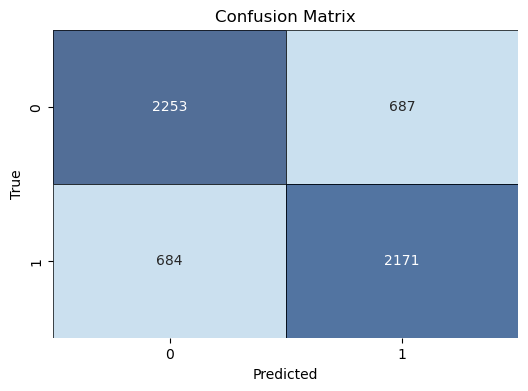

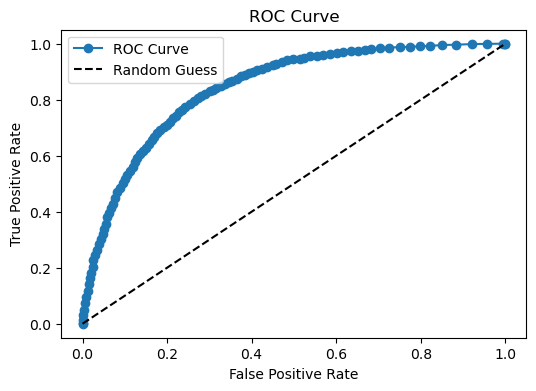

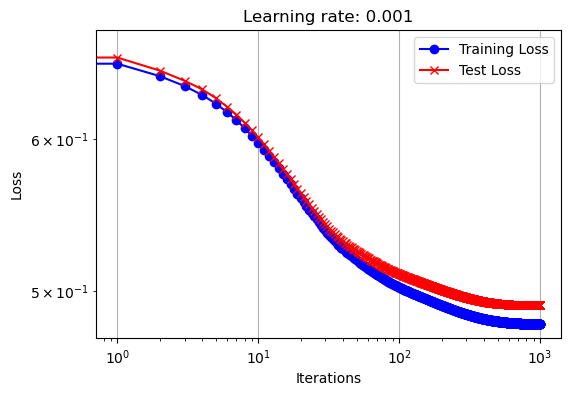

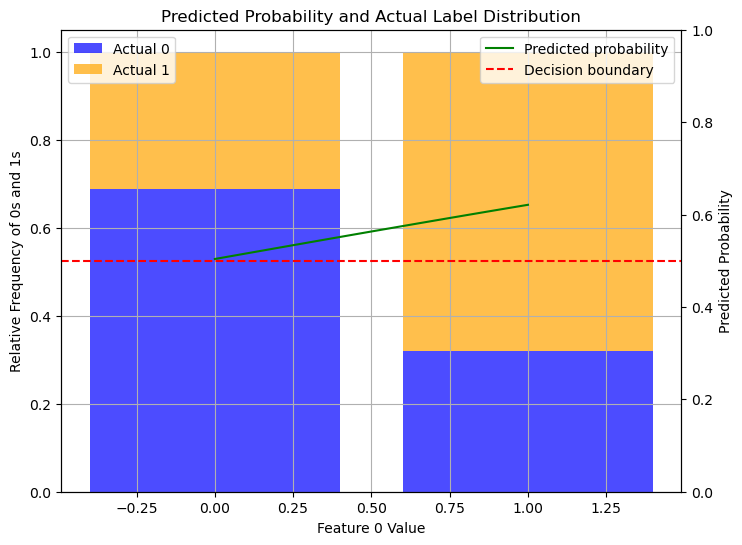

Features: ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')
 Acccuracy: 0.7634167385677308 F1 Score: 0.7600210047260634


In [115]:
#  LEARNING RATE SCHEDULER
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
mandatory_features = [] 
r = 29
results = evaluate_feature_combinations_with_mandatory(features_dict, X_train_balanced, Y_train_balanced,
                                                        r=r, mandatory_features=mandatory_features,
                                                        max_iters=1000, gamma= 0.001, beta1=0.9,
                                                        beta2=0.97, reg_norm= ['l2', 0.001], prob_threshold=0.52,
                                                        batch_size=4096, decay_rate=0.96 , decay_steps=100, plot=True)
for result in results:
    print(f"Features: {result['features']}")
    print(f" Acccuracy: {result['Accuracy']} F1 Score: {result['F1_score']}")

features:  ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')


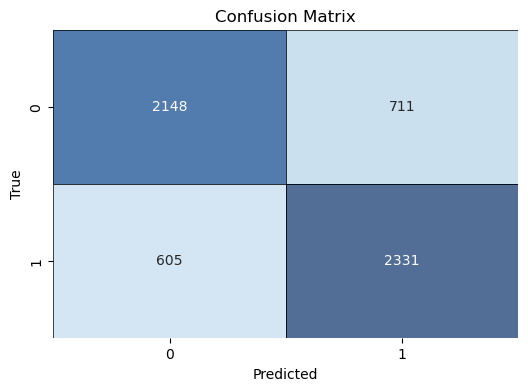

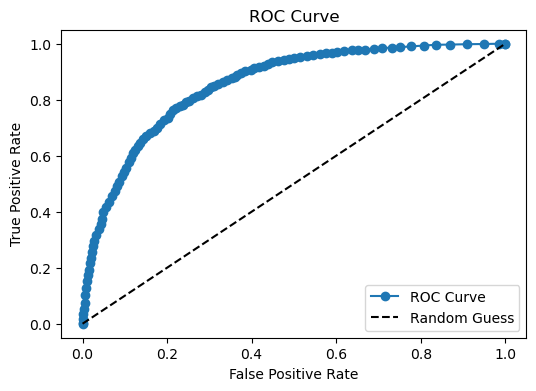

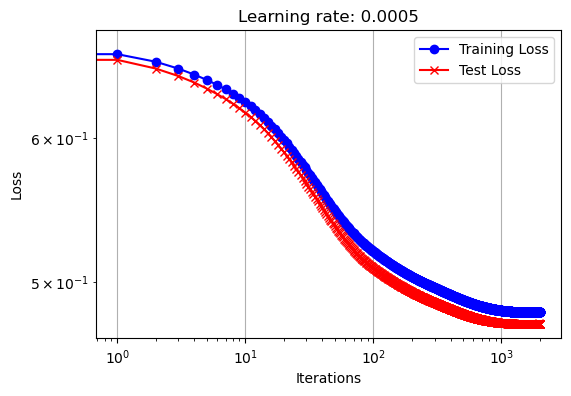

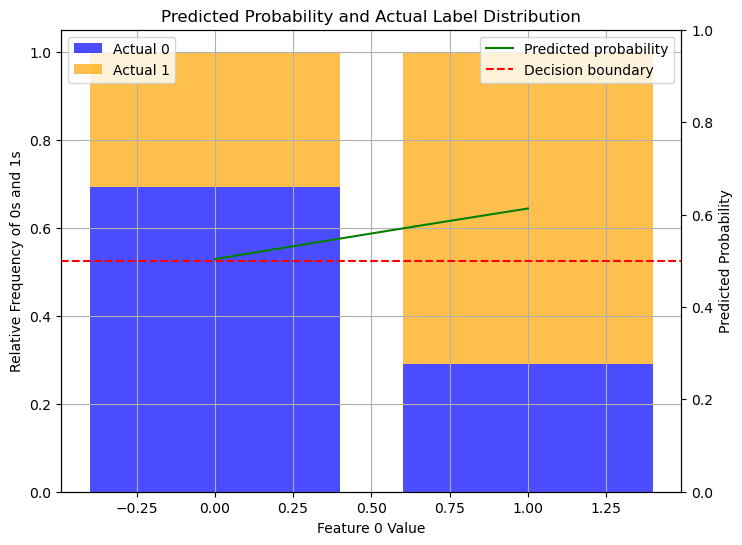

Features: ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')
 Acccuracy: 0.7729076790336497 F1 Score: 0.7798594847775175


In [107]:
#  LEARNING RATE SCHEDULER
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
mandatory_features = [] 
r = 29
results = evaluate_feature_combinations_with_mandatory(features_dict, X_train_balanced, Y_train_balanced,
                                                        r=r, mandatory_features=mandatory_features,
                                                        max_iters=2000, gamma= 0.0005, beta1=0.9,
                                                        beta2=0.97, reg_norm= ['l2', 0.001], prob_threshold=0.5,
                                                        batch_size=4096, decay_rate=0.99 , decay_steps=500, plot=True)
for result in results:
    print(f"Features: {result['features']}")
    print(f" Acccuracy: {result['Accuracy']} F1 Score: {result['F1_score']}")

features:  ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')


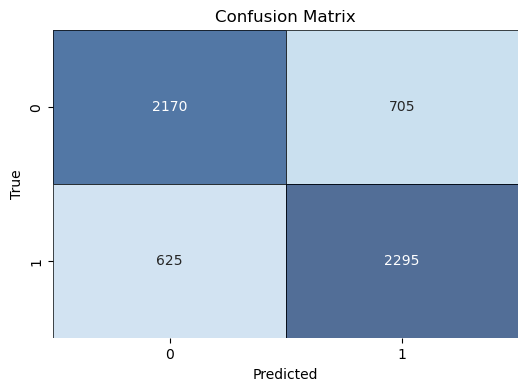

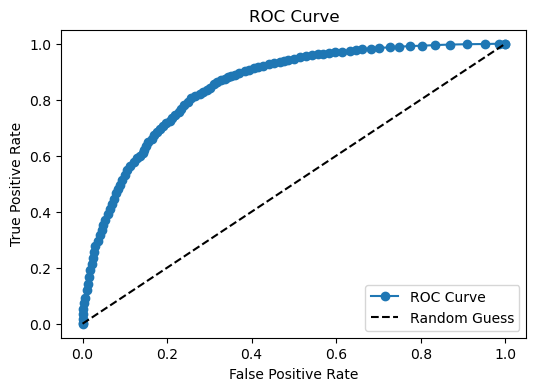

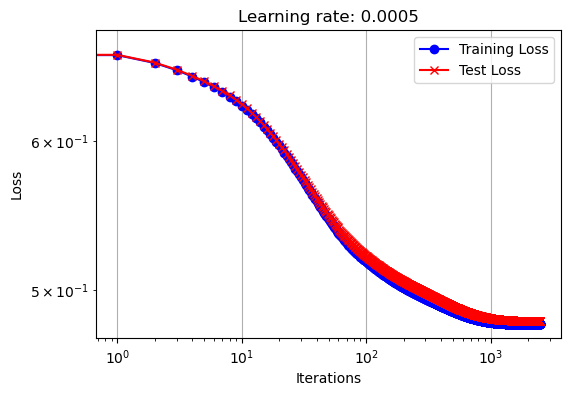

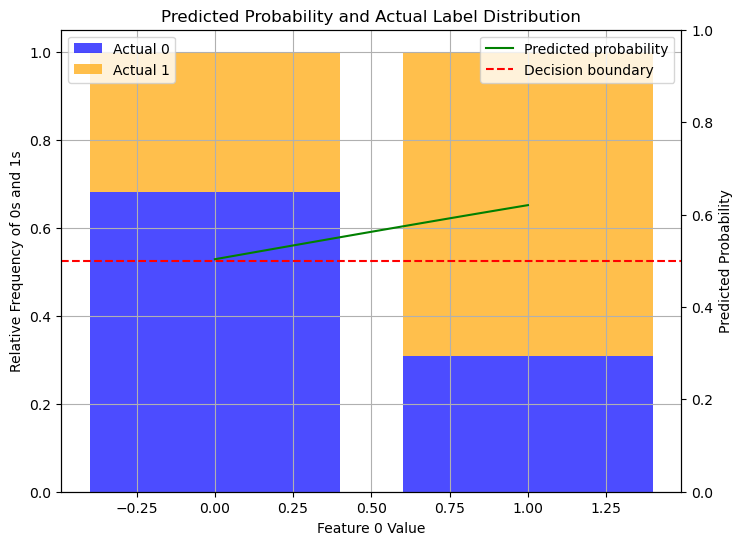

Features: ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')
 Acccuracy: 0.7704918032786885 F1 Score: 0.7753378378378378


In [91]:
#  FULL MODEL HYPERPARAM SEARCH
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
mandatory_features = [] 
r = 29
results = evaluate_feature_combinations_with_mandatory(features_dict, X_train_balanced, Y_train_balanced,
                                                        r=r, mandatory_features=mandatory_features,
                                                        max_iters=2000, gamma= 0.0005, beta1=0.9,
                                                        beta2=0.97, reg_norm= ['l2', 0.001], prob_threshold=0.5,
                                                        batch_size=4096,plot=True)
for result in results:
    print(f"Features: {result['features']}")
    print(f" Acccuracy: {result['Accuracy']} F1 Score: {result['F1_score']}")


  0%|          | 0/1 [00:00<?, ?it/s]

features:  ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')


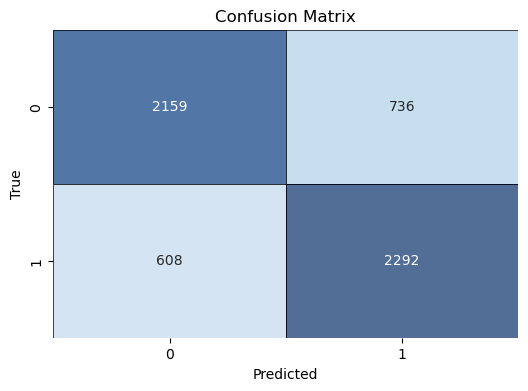

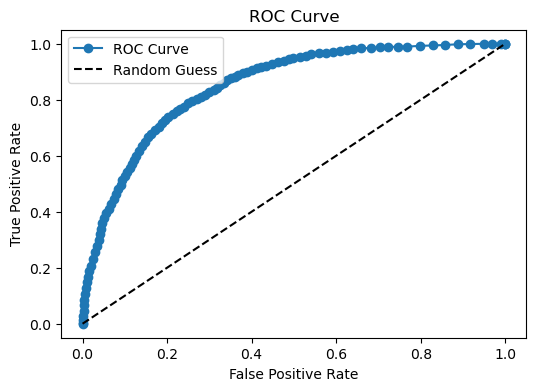

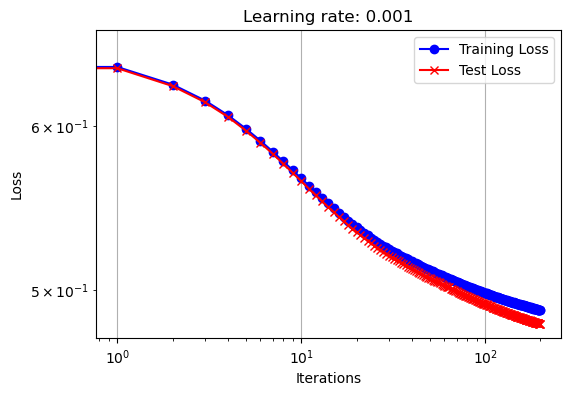

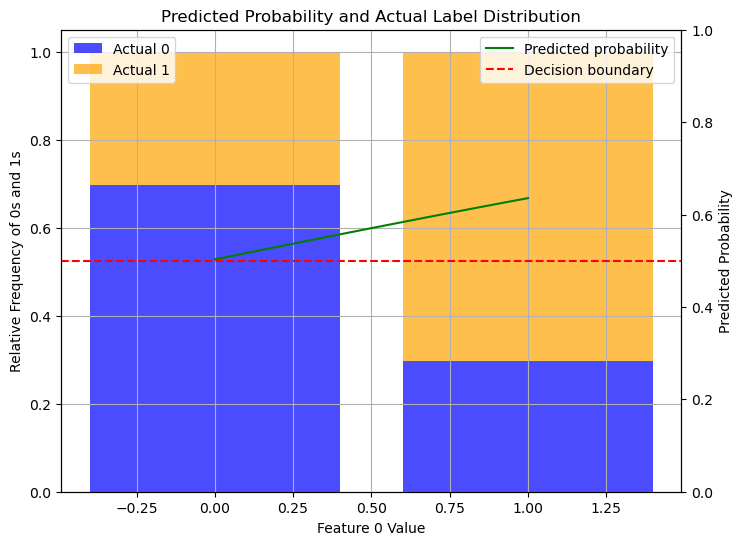

100%|██████████| 1/1 [00:04<00:00,  5.00s/it]

Features: ('BPMEDS', 'TOLDHI2', 'DIABETE3', 'HLTHPLN1', 'QLACTLM2', 'EXERANY2', 'ADDEPEV2', 'ASTHMA3', 'SMOKE100', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'SEX', 'BPHIGH4', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'ALCDAY5', 'CHECKUP1', 'STRENGTH', 'AVG_FRUITS_VEGS', '_RACEGR3', 'BMI', 'MENTHLTH', '_AGEG5YR', 'PHYSHLTH')
 Acccuracy: 0.7680759275237273 F1 Score: 0.7732793522267206


In [24]:
# FULL MODEL
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
mandatory_features = [] 
r = 29
results = evaluate_feature_combinations_with_mandatory(features_dict, X_train_balanced, Y_train_balanced,
                                                        r=r, mandatory_features=mandatory_features,
                                                        max_iters=200, gamma= 0.001, batch_size= 2048,
                                                          reg_norm='', prob_threshold = 0.5, plot=True)
for result in results:
    print(f"Features: {result['features']}")
    print(f" Acccuracy: {result['Accuracy']} F1 Score: {result['F1_score']}")


In [14]:

# 29 features
features_dict = {
    # Binary variables
    'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'EXERANY2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SMOKE100': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SEX': {'type': 'binary', 'missing_values': [np.nan]},
    'BPHIGH4': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'USEEQUIP': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'BLIND': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DECIDE': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFWALK': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFDRES': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFALON': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ALCDAY5': {'type': 'binary', 'missing_values': [np.nan]},
    'CHECKUP1': {'type': 'binary', 'missing_values': [np.nan]},
    'STRENGTH': {'type': 'binary', 'missing_values': [np.nan]},
    'AVG_FRUITS_VEGS': {'type': 'binary', 'missing_values': [np.nan]},

    # Categorical variable
    '_RACEGR3': {
        'type': 'categorical',
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]
    },

    # Numeric variables
    'BMI': {'type': 'numeric', 'missing_values': [7777, 9999, np.nan], 'range': (1, 4)},
    'MENTHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)},
    '_AGEG5YR': {'type': 'numeric', 'missing_values': [14, np.nan], 'range': (1, 13)},
    'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}
}

In [27]:

# 29 features
features_dict_binary_high = {
    # Binary variables
    'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'BPHIGH4': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'USEEQUIP': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'BLIND': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DECIDE': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFWALK': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFDRES': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'DIFFALON': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
}